# Random Forest for Rental Assistance

An exploration of the best random forest regressor for predicting the rentalAssistanceAmount.

In [3]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OneHotEncoder

# Metrics
from sklearn import metrics
from sklearn.decomposition import PCA

# Feature importance visulization
from xgboost import plot_importance
#import shap

In [4]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Load Data

In [5]:
# Load clean FL/TX data
df_clean = pd.read_csv("../../data/open-fema/FEMA-Large-Demographics-hud-FL-TX-clean.csv")
print('Without outliers:', len(df_clean))

Without outliers: 3187285


In [6]:
df_clean.head(3)

,disasterNumber,damagedCity,damagedStateAbbreviation,damagedZipCode,householdComposition,grossIncome,specialNeeds,homeOwnersInsurance,floodInsurance,inspected,rpfvl,habitabilityRepairsRequired,destroyed,waterLevel,floodDamage,foundationDamage,foundationDamageAmount,roofDamage,roofDamageAmount,tsaEligible,tsaCheckedIn,rentalAssistanceEligible,rentalAssistanceAmount,repairAssistanceEligible,repairAmount,replacementAssistanceEligible,replacementAmount,sbaEligible,renterDamageLevel,rentalAssistanceEndDate,rentalResourceCity,rentalResourceStateAbbreviation,rentalResourceZipCode,primaryResidence,personalPropertyEligible,ppfvl,censusBlockId,censusYear,id,censusTractId,fips,censusid,tractid,tractname,county,state,below_poverty_rate,median_earnings_total,unemployed_labor_rate,built_1979_or_earlier_rate,owner_occupied_rate_x,dvi,fmr0,fmr1,fmr2,fmr3,fmr4,occupied_housing_units_rate,vacant_housing_units_rate,owner_occupied_rate_y,haAmount,ownRent_Owner,ownRent_Renter,ownRent_Unknown,residenceType_Apartment,residenceType_Assisted Living Facility,residenceType_Boat,residenceType_College Dorm,residenceType_Condo,residenceType_Correctional Facility,residenceType_House/Duplex,residenceType_Military Housing,residenceType_Mobile Home,residenceType_Other,residenceType_Townhouse,residenceType_Travel Trailer,residenceType_Unknown
0,4337,MIRAMAR,FL,33023.0,1,0.0,0,0,0,0,0.0,1,0,0.0,0,0,0.0,0,0.0,0,False,0,0.0,0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1,False,0.0,120111105011006,2017,5c12d8dbf2238e6fe40c7edf,12011110501,12011,1400000US12011110501,12011110501,"Census Tract 1105.01, Broward County, Florida",Broward County,Florida,0.137643,24338.0,0.110277,0.894995,0.759124,0.822871,829,1023,1307,1883,2303,0.82581,0.17419,0.622614,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,4337,MIRAMAR,FL,33023.0,1,NaN,0,0,0,0,0.0,1,0,0.0,0,0,0.0,0,0.0,0,False,0,0.0,0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1,False,0.0,120111105012015,2017,5c12d8dbf2238e6fe40c80df,12011110501,12011,1400000US12011110501,12011110501,"Census Tract 1105.01, Broward County, Florida",Broward County,Florida,0.137643,24338.0,0.110277,0.894995,0.759124,0.822871,829,1023,1307,1883,2303,0.82581,0.17419,0.622614,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,4337,MIRAMAR,FL,33023.0,1,NaN,0,0,0,0,0.0,1,0,0.0,0,0,0.0,0,0.0,0,False,0,0.0,0,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,1,False,0.0,120111105011011,2017,5c12d8dbf2238e6fe40c8221,12011110501,12011,1400000US12011110501,12011110501,"Census Tract 1105.01, Broward County, Florida",Broward County,Florida,0.137643,24338.0,0.110277,0.894995,0.759124,0.822871,829,1023,1307,1883,2303,0.82581,0.17419,0.622614,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [7]:
def transform_rental(data):
    '''Transforms applied to the data in advance of rentalAssistanceAmount
    modeling stage, feature engineering and/or scaling. Accepts input of
    dataframe, outputs transformed dataframe.
    '''
    
    # Rental specific columns
    cols = ['householdComposition', 'primaryResidence', 'homeOwnersInsurance', 'floodInsurance', 'waterLevel',
            'habitabilityRepairsRequired', 'destroyed', 'floodDamage', 'foundationDamage', 'roofDamage',
            'inspected', 'rentalAssistanceEligible', 'rentalAssistanceAmount', 'fmr0', 'fmr1', 'fmr2',
            'fmr3', 'fmr4', 'occupied_housing_units_rate', 'vacant_housing_units_rate', 'owner_occupied_rate_y']
    
#     # Keep all fips columns
#     fips_cols = []
#     for col in data.columns:
#         if col[:4] == 'fips':
#             fips_cols.append(col)    
    
#     # All columns to keep (fips + rental specific)
#     cols.extend(fips_cols)
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

## Random Forest Regressor

https://machinelearningmastery.com/random-forest-ensemble-in-python/

- The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the size of the training dataset to make the bootstrap sample used to train each decision tree.
- max_features argument and defaults to the square root of the number of input features. 
- The number of trees can be set via the “n_estimators” argument and defaults to 100.
- The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default.

In [15]:
# Best parameters from original IHP GridSearch
# Obtained from RandomForest_Predict notebook

# {'bootstrap': True,
# 'max_depth': 10,
# 'max_samples': 0.9,
# 'min_samples_leaf': 5,
# 'n_estimators': 125}

In [9]:
def random_forest(data, n_estimators, max_depth, max_samples, min_samples_leaf, criterion, bootstrap):
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'rentalAssistanceAmount']
    y = data.loc[:, 'rentalAssistanceAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # Random Forest - fit the model
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               max_samples=max_samples,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               criterion=criterion,
                               random_state=42)
    rf.fit(X_train, y_train)

    # Predict
    y_pred = rf.predict(X_test)
    
    # Parameters and results
    print('Random Forest Regressor')
    print('Features: {}'.format(X_train.shape[1]))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))
    
    print('\nR^2 score: {:.4f}'.format(metrics.r2_score(y_test, y_pred)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    # Dollar amounts
    print('\nActual amount:    ${:,.2f}'.format(y_test.sum()))
    print('Predicted amount: ${:,.2f}'.format(y_pred.sum()))
    print('Difference: {:,.2f}'.format(y_pred.sum() - y_test.sum()))
    
    # Predictions off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('\nPreds off by 20%: {:.2f}%'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))  
    
    return(rf, y_pred, y_test)

In [10]:
def predict(df, model):
    X_test = df.loc[:, df.columns != 'rentalAssistanceAmount']
    y_test = df.loc[:, 'rentalAssistanceAmount']    
  
    print('Shape of Training and Test inputs')    
    print(X_test.shape, y_test.shape)
    
    return (model.predict(X_test), y_test)  

In [11]:
def evaluate(y_test, y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-squared:', metrics.r2_score(y_test, y_pred))
    print('\n')
    print('Total Rental Amount actual:    ${:,.2f}'.format(y_test.sum()))
    print('Total Rental Amount predicted: ${:,.2f}'.format(y_pred.sum()))
    print('\n')
    
    # Calculate the number of observations that are off by more than 20%
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['diff'] = results_df['predicted'] - results_df['actual']    
    results_df['percent_diff'] = (abs(abs(results_df['predicted'] / (results_df['actual'])) - 1) * 100).where(results_df['actual'] > 0, 0)    
    print('Percentage of predictions that are off by more than 20%: {:.2f}'.format( 
          len(results_df[results_df['percent_diff'] > 20])/len(results_df) * 100))   

In [12]:
def plot_importance(data, model):

    # Feature importance
    df_trim = data.loc[:, data.columns != 'rentalAssistanceAmount']
    importance = pd.DataFrame({'feature': df_trim.columns, 'importance': model.feature_importances_})
    importance.sort_values(by='importance', ascending=True, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.001]
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize = (7,7))
    ax.barh(trimmed_features['feature'], trimmed_features['importance'])
    ax.set_title('Random Forest: Feature Importance (n-estimators={})'.format(model.get_params()['n_estimators']))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    
    # Sort descending
    importance.sort_values(by='importance', ascending=False, inplace=True)
    
    return(importance)

### Clean data with HUD - Rental Assistance Amount

In [13]:
# Transform - no outliers
df_trim = transform_rental(df_clean)

# RandomForest - clean data
rf_rental, y_pred_rf, y_test_rf = random_forest(data=df_trim, n_estimators=125,
                                                              max_depth=10,
                                                              max_samples=0.9,
                                                              min_samples_leaf=5,
                                                              bootstrap=True,
                                                              criterion='mse')

# Save the model
pickle.dump(rf_rental, open('./models/rf-rental.sav', 'wb'))

Random Forest Regressor
Features: 20
Time (minutes): 5.4

R^2 score: 0.7340
MAE: 30.43
MSE: 117722.38
RMSE: 343.11

Actual amount:    $89,646,516.35
Predicted amount: $89,202,321.66
Difference: -444,194.69

Preds off by 20%: 2.02%


# Predict - Rental Assistance

In [14]:
# Load saved model
rf_rental = pickle.load(open('./models/rf-rental.sav', 'rb'))
print(rf_rental.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': 0.9, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 125, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [15]:
# Read in PR data
femaTestData = pd.read_csv('../../data/open-fema/FEMA-Large-Demographics-hud-PR-clean.csv')
print('There are {} records in our test dataset.'.format(len(femaTestData)))

# Transform test - rental
femaTestDf = transform_rental(femaTestData)
print(femaTestDf.shape)

There are 1041745 records in our test dataset.
(1041745, 21)


In [16]:
# Predict on test
y_pred_rf, y_test_rf = predict(femaTestDf, rf_rental)

Shape of Training and Test inputs
(1041745, 20) (1041745,)


In [17]:
# Evaluate predictions
evaluate(y_test_rf, y_pred_rf)

Mean Absolute Error: 64.57123978902528
Mean Squared Error: 66430.28612054995
Root Mean Squared Error: 257.7407343059105
R-squared: 0.4971076505178239


Total Rental Amount actual:    $105,907,418.42
Total Rental Amount predicted: $162,121,114.41


Percentage of predictions that are off by more than 20%: 9.53


In [18]:
# RF trim - observations
rf_rental_df = pd.DataFrame(y_test_rf)
rf_rental_df.columns = ['Actuals']

# Predictions and errors
rf_rental_df['Predictions'] = y_pred_rf
rf_rental_df['Errors'] = y_pred_rf - y_test_rf

rf_rental_df.describe()

,Actuals,Predictions,Errors
count,1.041745e+06,1.041745e+06,1.041745e+06
mean,1.016635e+02,1.556246e+02,5.396109e+01
std,3.634509e+02,4.615025e+02,2.520289e+02
min,0.000000e+00,0.000000e+00,-1.538747e+04
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00
max,1.719800e+04,2.777495e+03,1.928904e+03


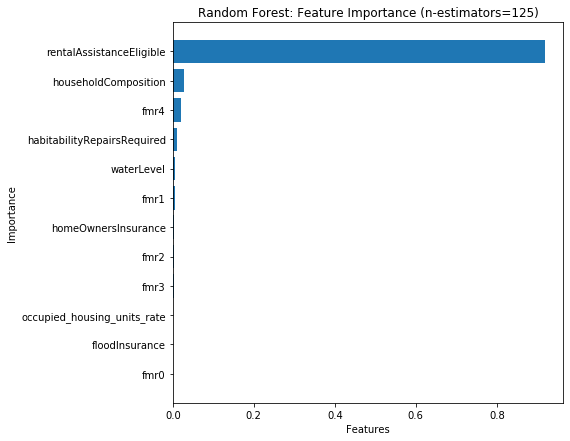

In [19]:
# Plot importance
rf_features = plot_importance(data=femaTestDf, model=rf_rental)

### Generate Prediction Files

In [20]:
# Append predictions to femaTestData
femaTestData['rentalAssistance_predicted'] = y_pred_rf

In [23]:
# Drop unnecessary columns
femaTestData.drop(['below_poverty_rate', 'unemployed_labor_rate', 'built_1979_or_earlier_rate',
                   'median_earnings_total', 'owner_occupied_rate_x', 'dvi'], axis=1, inplace=True)

In [24]:
femaTestData.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'homeOwnersInsurance', 'floodInsurance', 'inspected', 'rpfvl',
       'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
       'foundationDamage', 'foundationDamageAmount', 'roofDamage',
       'roofDamageAmount', 'tsaEligible', 'tsaCheckedIn',
       'rentalAssistanceEligible', 'rentalAssistanceAmount',
       'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id', 'censusTractId', 'fips',
       'censusid', 'tractid', 'tractname', 'county', 'state', 'fmr0', 'fmr1',
       'fmr2', 'fmr3', 'fmr4', 'oc

### Create PR Prediction Files

In [25]:
# Write aggregated predictions
femaTestData.to_csv("./predictions/FEMA-Large-PR-RENTAL-clean-predictions.csv", index=False, encoding='utf-8')